<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/modeling_VGG16/test_sample_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon Sep  5 15:24:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install -q wget datasets fire transformers

In [ ]:
! rm -rf PyTorch-Architectures/
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git

In [2]:
%cd PyTorch-Architectures/

/content/PyTorch-Architectures


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from modeling_VGG16 import VGG16
from toolkit.custom_dataset_cv import DataLoaderCIFAR10Classification
from toolkit.utils import dict_to_device
from toolkit import Trainer

In [4]:
! python -m unittest modeling_VGG16/test_model.py

..
----------------------------------------------------------------------
Ran 2 tests in 0.989s

OK


In [5]:
# Hyperparameters
INPUT_SIZE = 32
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 3

In [6]:
train_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, 
                                               train=True,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

valid_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, 
                                               train=False,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

print(f"Length of Train Loader --> {len(train_loader)}")
print(f"Length of Valid Loader --> {len(valid_loader)}")

cifar10 extracted...
cifar10 exists...
Length of Train Loader --> 196
Length of Valid Loader --> 40


In [7]:
# Sanity check DataLoader
for sample in train_loader:
  assert sample["pixel_values"].dim() == 4
  assert sample["pixel_values"].size(2) == INPUT_SIZE
  break

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=10)
model.to(device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters --> {params}")

Trainable Parameters --> 33638218


In [9]:
# Sanity check forward pass
model.eval()
with torch.set_grad_enabled(False):
  for sample in train_loader:
    loss, logits = model(**dict_to_device(sample, device=device))
    print(f"Loss --> {loss.item(): .2f}")
    print(f"Logits Shape --> {logits.shape}")
    break

Loss -->  2.38
Logits Shape --> torch.Size([256, 10])


In [10]:
trainer = Trainer(model=model,
                  train_dataset=train_loader,
                  valid_dataset=valid_loader,
                  optimizer="adam",
                  scheduler=None,
                  lr=LEARNING_RATE,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  gradient_accumulation_steps=2,
                  use_amp=False,
                  eval_metric="cv_accuracy",
                  show_grad_flow=True
                  )

********** Running Training **********
  Total Training Steps = 588  
  Epochs = 3  
  Batch Size = 256  
  Length of Train DataLoader = 196  
  Length of Valid DataLoader = 40  


  0%|          | 0/588 [00:00<?, ?it/s]


Epoch: 1 || Training Loss: 2.528 || cv_accuracy: 29.780

Gradient-Flow for epoch 1


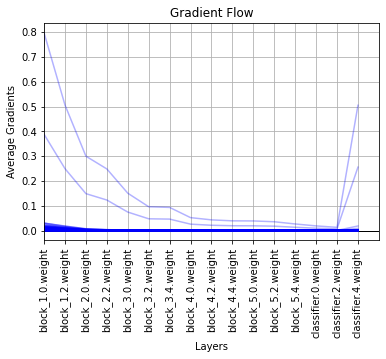


Epoch: 2 || Training Loss: 1.681 || cv_accuracy: 40.370

Gradient-Flow for epoch 2


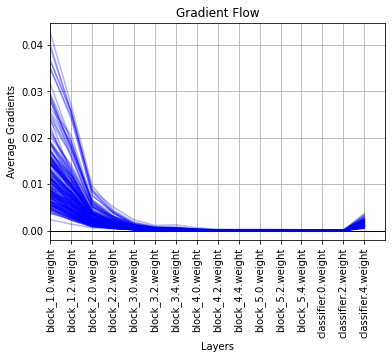


Epoch: 3 || Training Loss: 1.458 || cv_accuracy: 48.680

Gradient-Flow for epoch 3


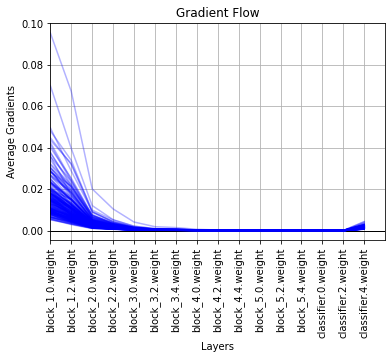

In [11]:
trainer.train()